# Monet like Image Generation
The objective of this work is to bring that style of Monet using images of artist Monet, to photos (non Monet) that are provided. The notebook follows Tensorflow's direction to use CycleGAN to meet this objective.

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the image. This generator is trained using a discriminator. The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Cycle GAN's are conditional GAN that performs unpaired image to image translation. That is it captures the characteristics of one image domain (Monet style in our example) and figure out how these characteristics could be translated into another image domain (normal photos in our case)

GitHub: https://github.com/suchig/DTSA-5511-Week5

## Data
The dataset provided by Kaggle (https://www.kaggle.com/competitions/gan-getting-started/data) contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. For this work, only monet_tfrec and photo_tfrec were used

Monet - 300 Monet paintings sized 256x256\
Photo - 7028 photos sized 256x256 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

Below grabs the filenames from TF Record

In [2]:
datafolder = KaggleDatasets().get_gcs_path("gan-getting-started")

MONET_FILENAMES = tf.io.gfile.glob(str(datafolder + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(datafolder + '/photo_tfrec/*.tfrec'))
IMAGE_SIZE = [256, 256]


Decode image does the following, given a jpeg image
- Converts JPEG image to uint8 tensor
- Normalizes in [-1, 1] range. This is needed for GANs
- flips images left or right randomly (Per tensorflow documentation)

In [3]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    image = tf.image.random_flip_left_right(image)
    return image

Below reads each record from TFRecord and decodes the same into tensor

In [4]:
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Below reads the files in TFRecord and converts into a batch of tensor of images dataset

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

Below loads all files into datasets

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

Here is an example Photo and Monet image

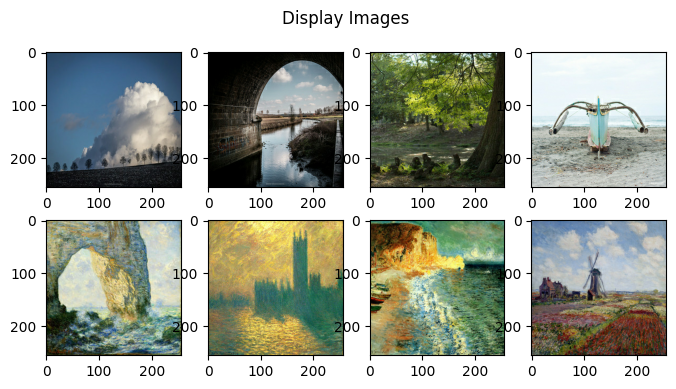

In [16]:
monet_ds.shuffle(1000)
photo_ds.shuffle(1000)

_, ax = plt.subplots(2, 4, figsize=(8, 4))
plt.suptitle("Display Images")

for i, img in enumerate(photo_ds.take(4)):
    ax[0, i].imshow(img[0] * 0.5 + 0.5)

for i, img in enumerate(monet_ds.take(4)):
    ax[1, i].imshow(img[0] * 0.5 + 0.5)
plt.show()

## Model
The Cycle GAN follows pix2pix example in Tensorflow(https://www.tensorflow.org/tutorials/generative/pix2pix). Like any GAN It contains a generator and a discriminator. In this cycleGAN,
- Generator - contains a UNET architecture of Downsampling and UpSampling images so that images are restored
- Discriminator - Convolutional PatchGAN Classifier that tries to classify if each image patch is real or not real

### Step 1 - Define UNet
A U-Net containes encoder that downsamples images to identify the core features and upsamples to provide the features in the context of whole images. This is traditionally used in Medical Imaging

- Downsampling
    - Convolution layer
        - I removed kernel initializer to see what the impact is
    - Normalization layer
    - LeakyReLU
- Upsampling
    - Deconvolution layer (Transpose)
    - Normalization Layer
    - Dropout
        - I changed the parameter to 0.3 from 0.5 from the pix2pix guidance
    - LeakyReLU
        - I changed from ReLU to LeakyReLU
    

In [17]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same'))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=True):
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.3))

    result.add(layers.LeakyReLU())

    return result

### Step 2a Define Generator
Since this follows UNet architecture, 
- Downward Path
    - A layer of downsample with 64 filters of size 4 each
    - A layer of downsample with 128 filters of size 4 each
    - A layer of downsample with 256 filters of size 4 each
    - 3 layers of downsample with 512 filters of size 4 each
        - I changed 5 to 3 layers
- Upward Path
    - 2 layers of upsample with 512 filters of size 4 each
        - I changed 4 to 2 layers
    - A layer of upsample with 256 filters of size 4 each
    - A layer of upsample with 128 filters of size 4 each
    - A layer of upsample with 64 filters of size 4 each
- Concatenation
    - Every Downsample layer concatenates to upsample layer

In [18]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Step 2b Define Discriminator

This contains
- 3 Downsample Layers of progressive filters
- Convolution ->  normalization -> Leaky ReLU.
- The shape of the output after the last layer is (batch_size, 30, 30, 1).


In [19]:
def Discriminator():
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    
    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                            )(zero_pad2)
    return tf.keras.Model(inputs=inp, outputs=last)

### Step 3: Create Discriminators and Generators

In [20]:
monet_generator = Generator() # transforms photos to Monet-esque paintings
photo_generator = Generator() # transforms Monet paintings to be more like photos

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos

#### Visualize structure of Generator

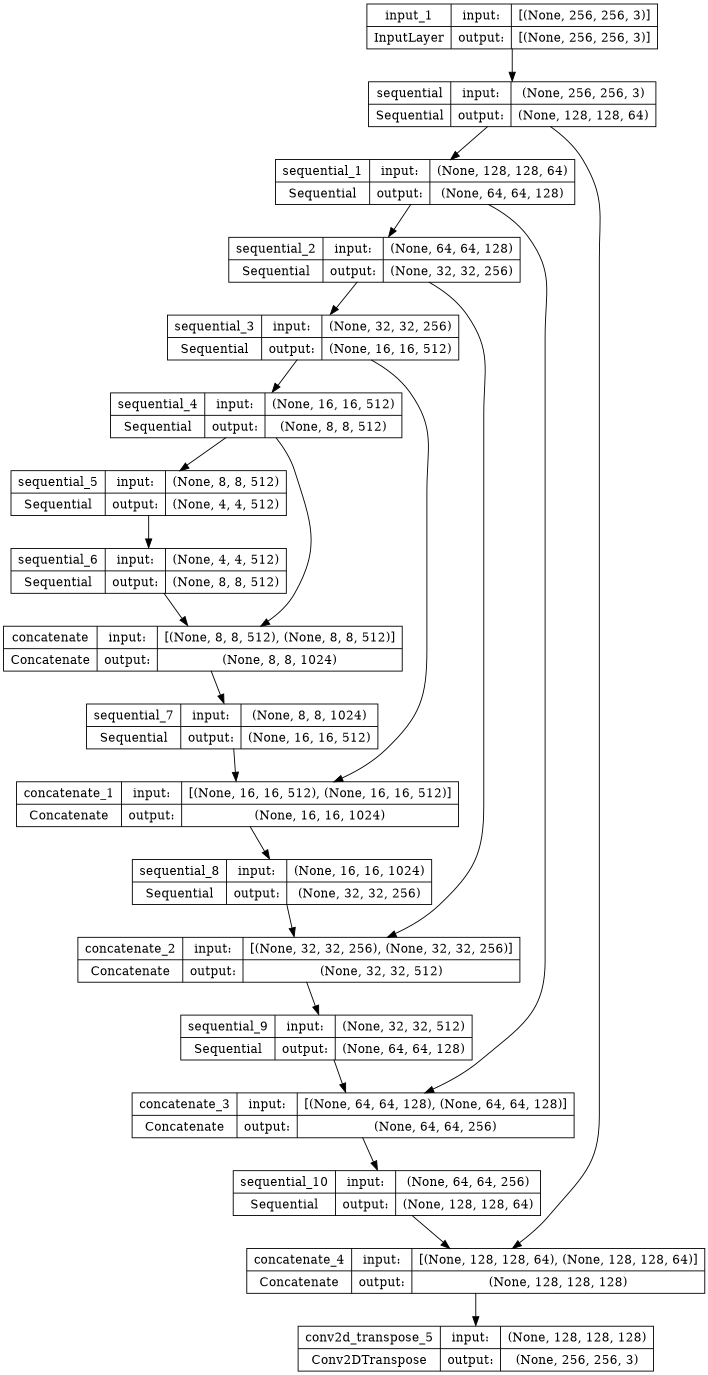

In [21]:
tf.keras.utils.plot_model(monet_generator, show_shapes=True, dpi=64)

#### Visualizing how Generator works
As it can be seen Monesque photo is just a dark image as model is not trained

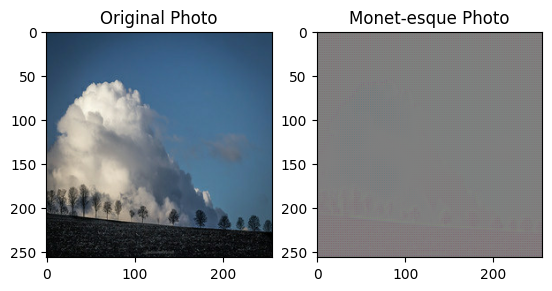

In [24]:
img = next(iter(photo_ds))
to_monet = monet_generator(img)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(img[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

#### Visualizing Monet Discriminator

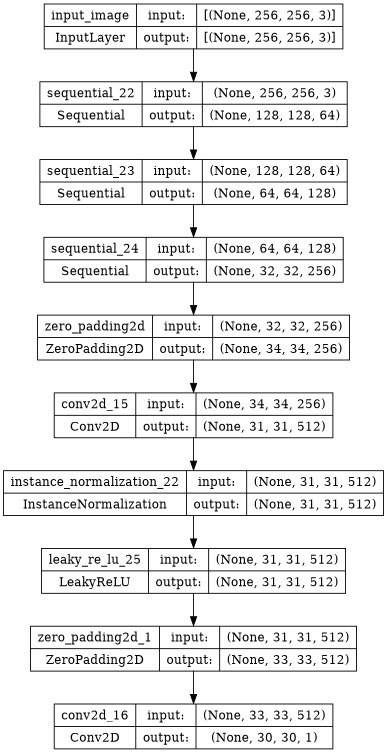

In [25]:
tf.keras.utils.plot_model(monet_discriminator, show_shapes=True, dpi=64)

#### Visualizing how an untrained Discrinator views a Monet image

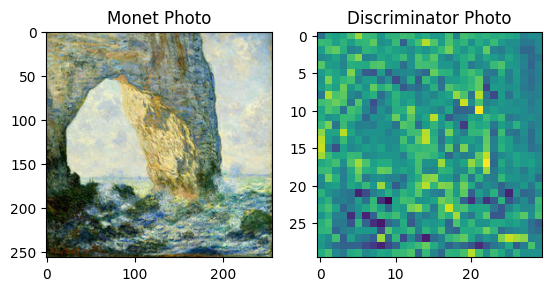

In [26]:
img = next(iter(monet_ds))

disc_out = monet_discriminator(img, training=False)
plt.subplot(1, 2, 1)
plt.title("Monet Photo")
plt.imshow(img[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Discriminator Photo")
plt.imshow(disc_out[0] * 0.5 + 0.5)
plt.show()

### Step 4: Define the overall Model

There are 2 generators (monet_generator(G) and photo_generator(F)) and 2 discriminators ( monet_discriminator(D_X) and photo_discriminator(D_Y)) being trained here. Assuming X and Y are Monet image and Photo images

- Generator G learns to transform image X to image Y. (G: X -> Y)
- Generator F learns to transform image Y to image X. (F: Y-> X)
- Discriminator D_X learns to differentiate between image X and generated image X (F(Y)).
- Discriminator D_Y learns to differentiate between image Y and generated image Y (G(X)).

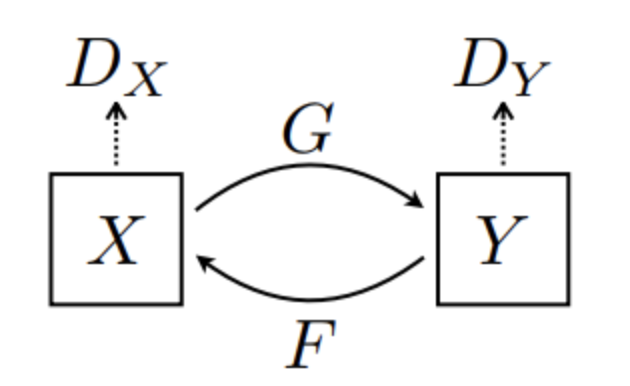

In [65]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Step 5 Define Losses
1. Generator Loss:
- Very similar to what was learnt in GAN class. It is assumed that the generated image is close to real image and hence BCEloss is done with true values of 1

2. Discriminator Loss:
The two components here are
- real_loss - This is loss pertaining to discriminators output of real image and hence it is compared with all 1s
- gen_loss - This is loss pertaining to discriminator's out of generated image. Since Generator and Discriminator act as yin and yang, this can be compared with all 0s

3. Cycle Loss: 
- In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input x and the target y pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, cycle consistency loss is used. Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the original sentence. 
- This is why this is absolute value of (real image - cycled image)

4. Identity Loss:
- If an image is fed to a generator, it should yield the real image or something close to that image. Note that this is not cycled image that comes back after a cycle. It is the "same image" or what is called as "generating itself" in the above section
- This is defined by absolute value of (real image - same image)

In [66]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

### Step 6: Defining Optimizers and Model Creation

In [67]:
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

### Step 7: Actual Training

In [68]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=50
)

Epoch 1/50


2023-11-14 07:33:35.440153: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/sequential_62/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 99s 183ms/step - monet_gen_loss: 4.8588 - photo_gen_loss: 4.9949 - monet_disc_loss: 0.6656 - photo_disc_loss: 0.6677
Epoch 2/50
300/300 [==============================] - 56s 183ms/step - monet_gen_loss: 3.4800 - photo_gen_loss: 3.5740 - monet_disc_loss: 0.6628 - photo_disc_loss: 0.6412
Epoch 3/50
300/300 [==============================] - 56s 183ms/step - monet_gen_loss: 3.2020 - photo_gen_loss: 3.3530 - monet_disc_loss: 0.6603 - photo_disc_loss: 0.6197
Epoch 4/50
300/300 [==============================] - 56s 183ms/step - monet_gen_loss: 3.0488 - photo_gen_loss: 3.1946 - monet_disc_loss: 0.6413 - photo_disc_loss: 0.6038
Epoch 5/50
300/300 [==============================] - 56s 183ms/step - monet_gen_loss: 2.9660 - photo_gen_loss: 3.0643 - monet_disc_loss: 0.6281 - photo_disc_loss: 0.6143
Epoch 6/50
300/300 [==============================] - 56s 183ms/step - monet_gen_loss: 2.9089 - photo_gen_loss: 2.9739 - monet_disc_loss: 0.6188 - photo_dis

In [34]:
#Helper to plot losses 
def plot_history(hist):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['monet_gen_loss'], label='Monet Generator Loss')
    plt.plot(hist.history['photo_gen_loss'], label='Photo Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['monet_disc_loss'], label='Monet Discriminator Loss')
    plt.plot(hist.history['photo_disc_loss'], label='Photo Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Visualizing images after Training

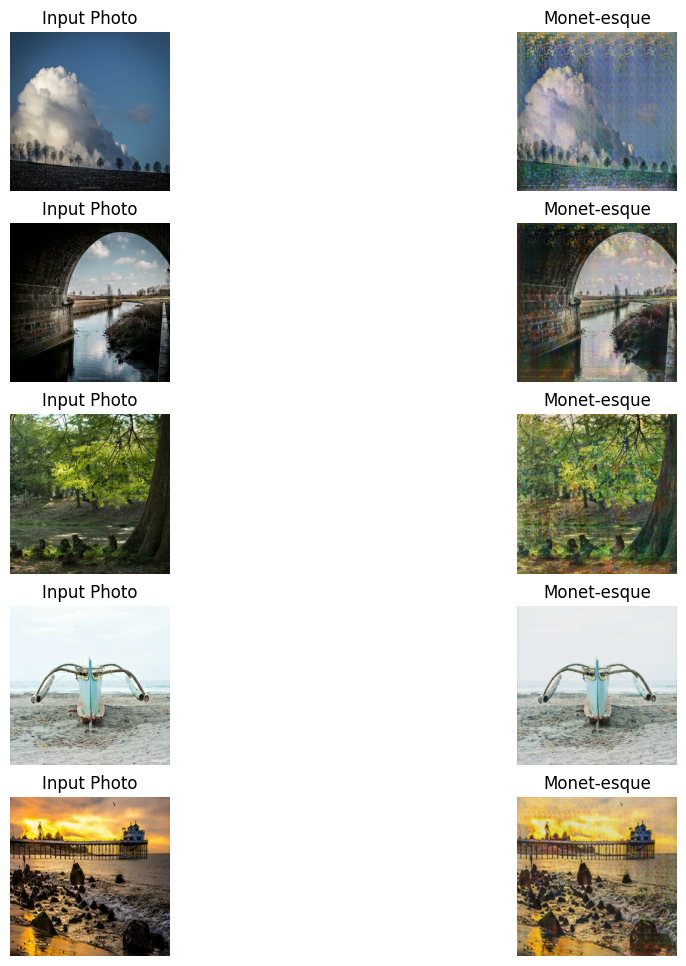

In [69]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Submission

In [72]:
import PIL
import os
save_dir = '../images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In the actual, it creates zip files as images.zip not submission.zip. I changed this code but did not run in my notebook version to conserve GPU time

In [73]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/submission.zip'

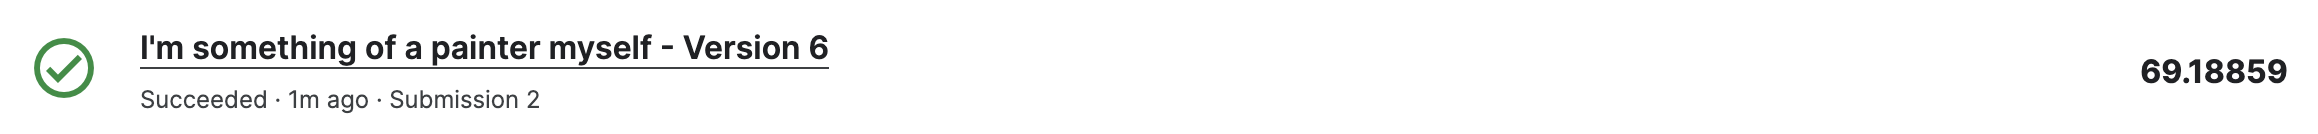

The above score is not really great. But it does provide a starter

## Conclusion and Lesson learned
1. This project was more a learning than a trial with knowledge. I went through tensorflow's implementation of CycleGAN, pix2pix and also read through some important parts of the paper
2. The portion that feeds like a cycle was a big learning curve.
3. I tried to introduce some augmentations by flipping the images
4. I modified the architecture a little bit to see its impact and it was satisfactory
5. I could add more augmentations between Generator and Discriminator to improve the result
6. I sillied a lot in conversion of images to zip files. This costed me more than 4 hours of GPU time that I could have used for some other project. I think I should have isolated this in CPU and then moved to GPU.
5. Overall, I still believe I need to do more Cycle GAN based projects and learn how to improve this result

## References
1. https://www.tensorflow.org/tutorials/generative/pix2pix
2. https://www.tensorflow.org/tutorials/generative/cyclegan
3. https://arxiv.org/abs/1703.10593
4. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook